---
**License**

 NumCosmoCCLTest

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 NumCosmoCCLTest\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
import pylab as plt
def compare(x, y_ccl, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(12, 6)}, xscale = 'linear', yscale = 'log'):
    ccl_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    
    x     = np.array (x)
    y_ccl = np.array (y_ccl)
    y_nc  = np.array (y_nc)
    diff  = np.zeros_like (y_ccl)
    
    non_zind = np.where (y_ccl != 0.0)[0]
    zind     = np.where (y_ccl == 0.0)[0]
    diff[non_zind] = y_nc[non_zind]/y_ccl[non_zind] - 1.0
    diff[zind]     = y_nc[zind] - y_ccl[zind]
    print('[%10s]: rel diff min: %e\trel diff max: %e'%(y_name, min(abs(diff)), max(abs(diff))))
        
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_ccl, label='ccl', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, np.abs (diff), c='r')
    #axs[1].axhline(0, ls=':', c='0', lw=.5)
    axs[1].set_xscale (xscale)
    axs[1].set_yscale (yscale)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, ccl_name))
    
    return fig, axs

In [4]:
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h       = 0.7
A_s     = 2.1e-9
n_s     = 0.96
Neff    = 0.0
mu_0    = 0.1
sigma_0 = 0.1

Omega_v_vals = np.array([0.7, 0.7, 0.7, 0.65, 0.75])
w0_vals      = np.array([-1.0, -0.9, -0.9, -0.9, -0.9])
wa_vals      = np.array([0.0, 0.0, 0.1, 0.1, 0.1])

mnu = [
    [0.04, 0., 0.], [0.05, 0.01, 0.], [0.05, 0., 0.],
    [0.03, 0.02, 0.]]
Neff_mnu = 3.0


In [5]:
def compare_distances(z, Omega_v, w0, wa):
    """
    Compare distances calculated by pyccl with the distances in the benchmark
    file.
    This test is only valid when radiation is explicitly set to 0.
    """
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, A_s=A_s, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0)
    
    ccl_cosmo.cosmo.gsl_params.INTEGRATION_EPSREL = 1.0e-13 # Doesn't seem to work
    ccl_cosmo.cosmo.gsl_params.A_SPLINE_NLOG      = 100000  # Doesn't seem to work
    ccl_cosmo.cosmo.gsl_params.A_SPLINE_NA        = 100000  # Doesn't seem to work
        
    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h*100)
    cosmo.param_set_by_name ("Omegak",    Omega_k)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
    cosmo.param_set_by_name ("Tgamma0",   0.0)
        
    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    print (dist.comoving_distance_spline.props.reltol)
    print (dist.comoving_distance_spline.props.abstol)
    print (dist.comoving_distance_spline.peek_spline().get_len())
    
    a = 1. / (1. + z)    

    ccl_Og = ccl.omega_x (ccl_cosmo, a, 'matter')
    nc_Og  = [cosmo.E2Omega_m (z_i) / cosmo.E2 (z_i) for z_i in z]
    
    compare (z, ccl_Og, nc_Og, x_name = 'z', y_name = '\Omega_m{}')
    
    ccl_E = ccl.h_over_h0 (ccl_cosmo, a)
    nc_E  = [cosmo.E (z_i) for z_i in z]
    
    compare (z, ccl_E, nc_E, x_name = 'z', y_name = 'E')
    
    ccl_chi = ccl.comoving_radial_distance(ccl_cosmo, a)
    RH_Mpc  = cosmo.RH_Mpc ()
    nc_chi  = [dist.comoving (cosmo, z_i) * RH_Mpc for z_i in z]
    
    compare (z, ccl_chi, nc_chi, x_name = 'z', y_name = 'D')


2.220446049250313e-16
2.2204460492503132e-26
17320
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.270655e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 9.380030e-06
2.220446049250313e-16
2.2204460492503132e-26
17599
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.253896e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 8.635977e-06
2.220446049250313e-16
2.2204460492503132e-26
16469
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 5.551115e-16
[         E]: rel diff min: 0.000000e+00	rel diff max: 4.239765e-06
[         D]: rel diff min: 0.000000e+00	rel diff max: 8.306690e-06
2.220446049250313e-16
2.2204460492503132e-26
18045
[\Omega_m{}]: rel diff min: 0.000000e+00	rel diff max: 6.661338e-16
[         E]: rel diff min: 2.220446e-16	rel diff max: 4.194554e-06
[         D]: rel diff min: 0.000000e+00	rel dif

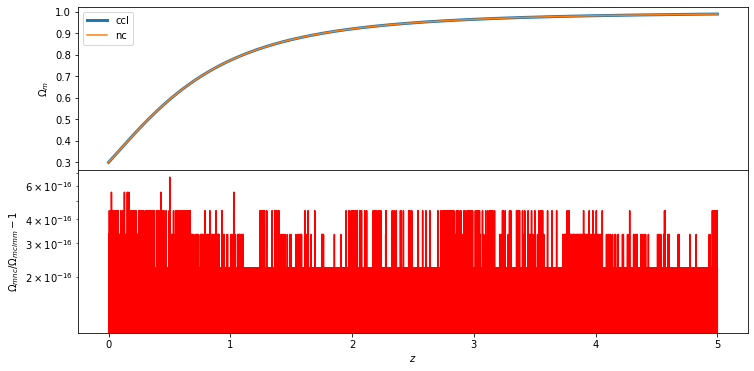

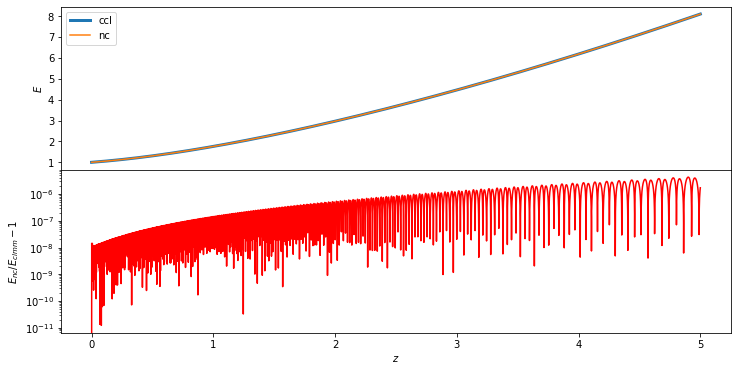

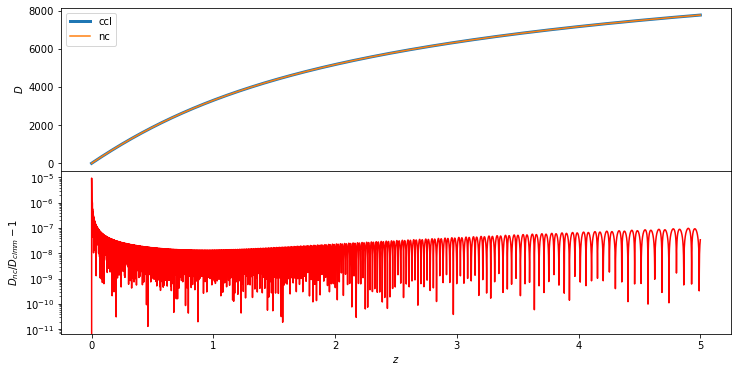

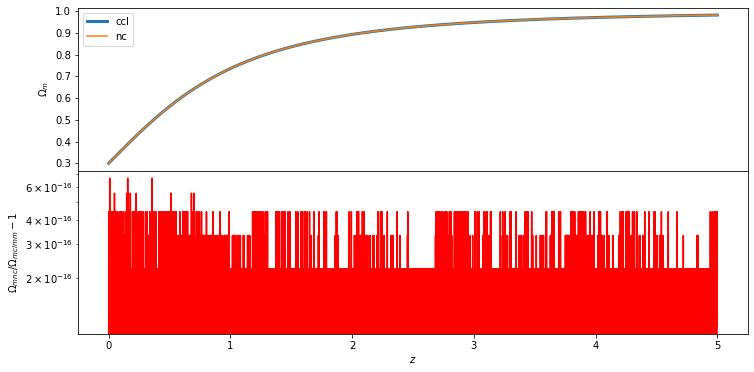

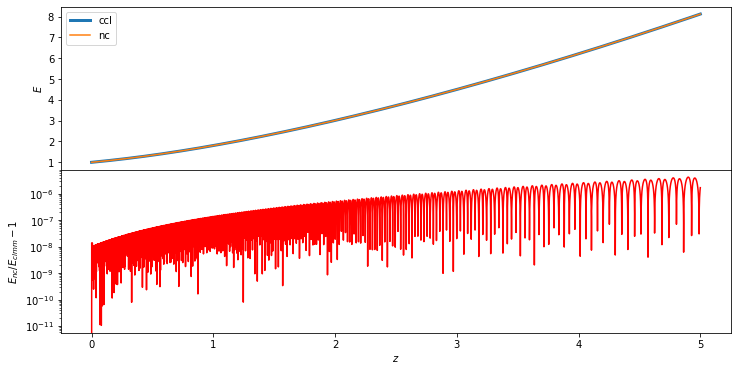

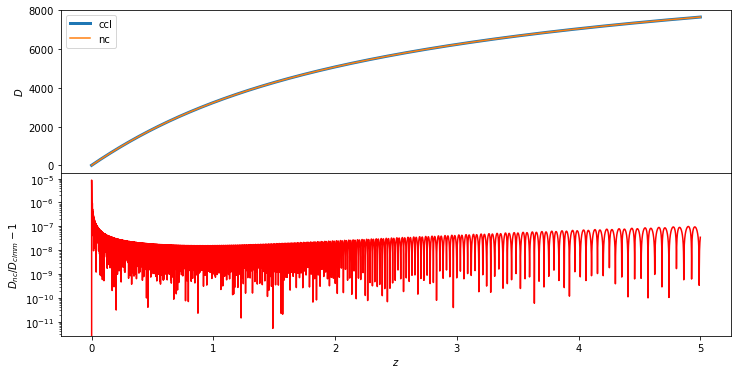

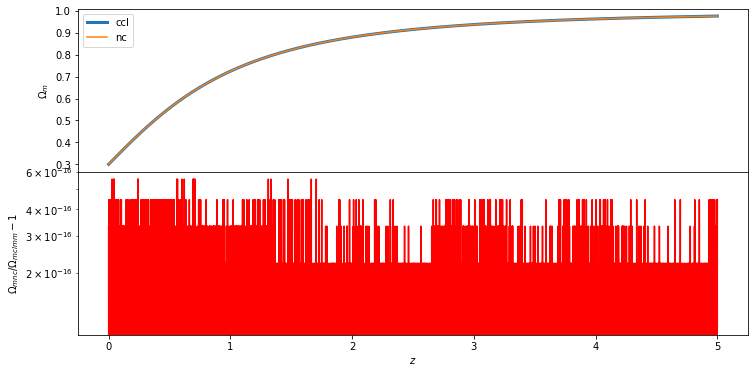

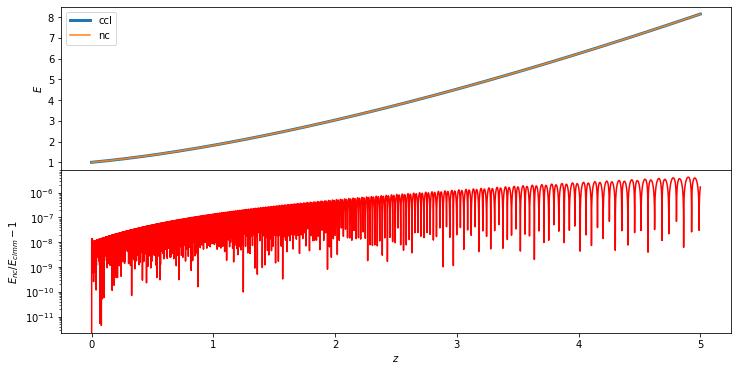

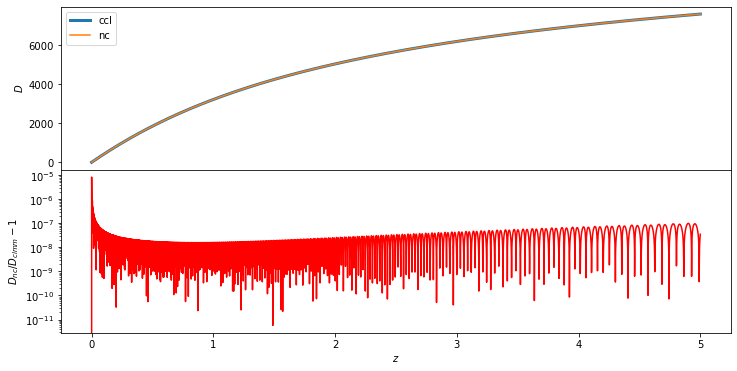

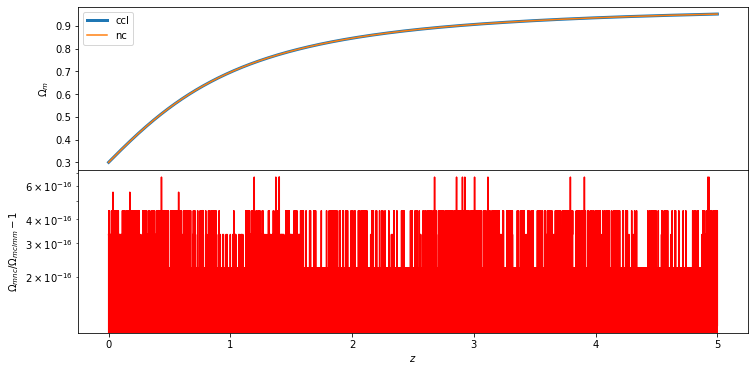

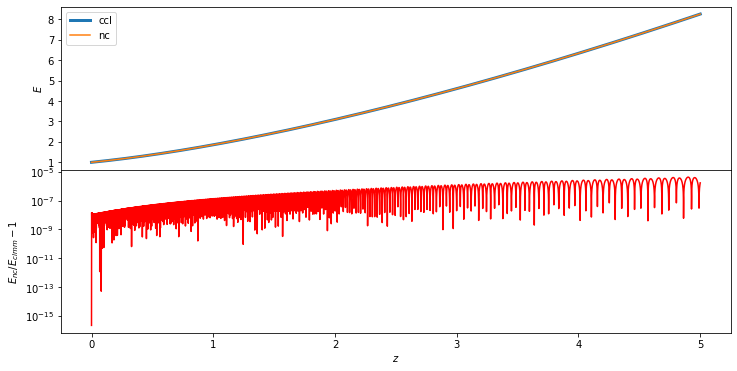

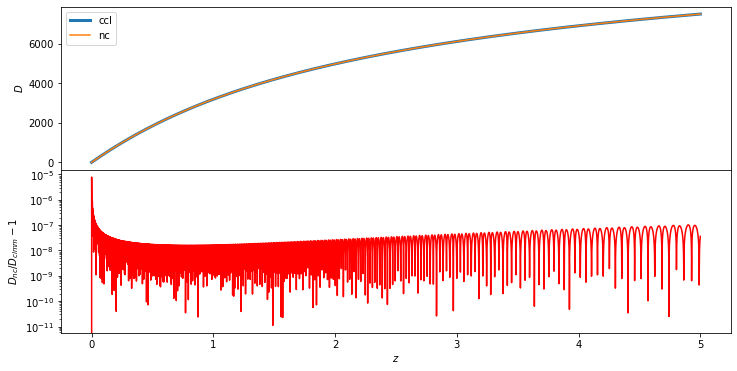

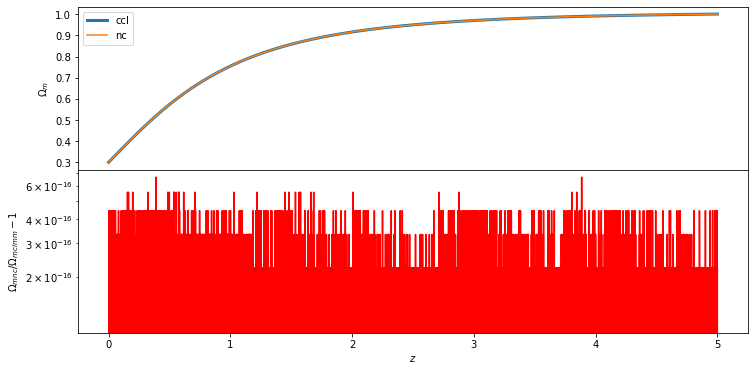

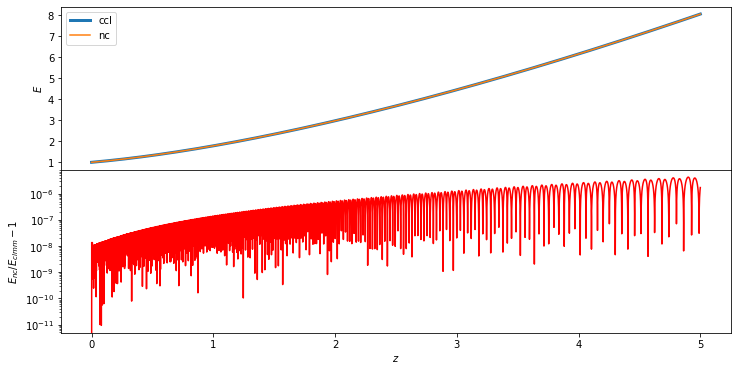

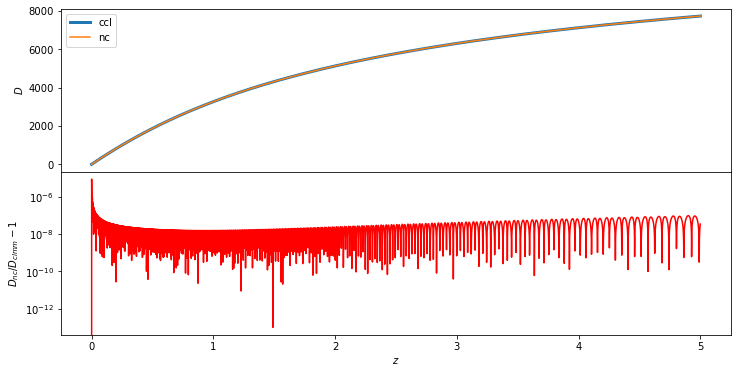

In [6]:
z = np.linspace (0.0, 5.0, 10000)

for i in range(5):
    compare_distances(z, Omega_v_vals[i], w0_vals[i], wa_vals[i])


In [180]:
def compare_ps (k, z, Omega_v, w0, wa):
    """
    Compare ...
    """

    cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
    cosmo.omega_x2omega_k ()
    cosmo.param_set_by_name ("H0",        h * 100)
    cosmo.param_set_by_name ("Omegak",    0.0)
    cosmo.param_set_by_name ("w0",        w0)
    cosmo.param_set_by_name ("w1",        wa)
    cosmo.param_set_by_name ("Omegab",    Omega_b)
    cosmo.param_set_by_name ("Omegac",    Omega_c)
    cosmo.param_set_by_name ("ENnu",      Neff)
    
    # Set Omega_K in a consistent way
    Omega_k = cosmo.Omega_k0 ()
    Omega_v = cosmo.E2Omega_de (0.0)
    T_CMB   = cosmo.T_gamma0 ()

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
        h=h, n_s=n_s, Omega_k=Omega_k,
        w0=w0, wa=wa, Omega_g=0, sigma8 = 0.8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear')

    hiprim = Nc.HIPrimPowerLaw.new ()
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
    hiprim.param_set_by_name ("n_SA",       n_s)
    
    cosmo.add_submodel (hiprim)
    
    dist = Nc.Distance.new (5.0)
    dist.prepare (cosmo)
    
    tf_eh = Nc.TransferFuncEH.new ()
    tf_eh.props.CCL_comp = True
    ps_eh = Nc.PowspecMLTransfer.new (tf_eh)
    ps_eh.prepare (cosmo)
    
    fact = (0.8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))**2
    
    #fact = ccl.linear_matter_power (ccl_cosmo, 1.0e-1, 1.0) / ps_eh.eval (cosmo, 0.0, 1.0e-1)
    
    hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s * fact))
    
    (k_min, k_max) = (min (k), max (k))
    (z_min, z_max) = (min (z), max (z))

    ps_eh.set_kmin (k_min)
    ps_eh.set_kmax (k_max)
    ps_eh.require_zi (z_min)
    ps_eh.require_zf (z_max)

    ps_eh.prepare (cosmo)
    
    for z_i in z:
        a_i = 1.0 / (1.0 + z_i)
        pk_ccl = ccl.linear_matter_power (ccl_cosmo, k, a_i)
        pk_nc  = [ps_eh.eval (cosmo, z_i, k_i) for k_i in k]
        compare (k, pk_ccl, pk_nc, x_name = 'k', y_name = 'P_k(%f)' % z_i, xscale = 'log')    


[P_k(0.000000)]: rel diff min: 5.470260e-04	rel diff max: 5.492323e-04
[P_k(0.500000)]: rel diff min: 5.769134e-04	rel diff max: 5.791198e-04
[P_k(1.000000)]: rel diff min: 6.407914e-04	rel diff max: 6.429980e-04


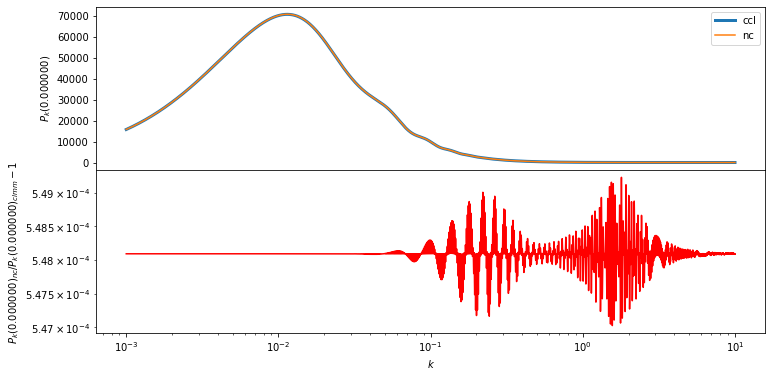

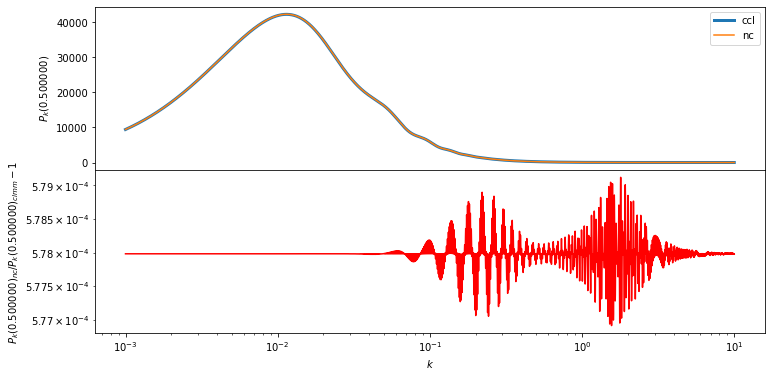

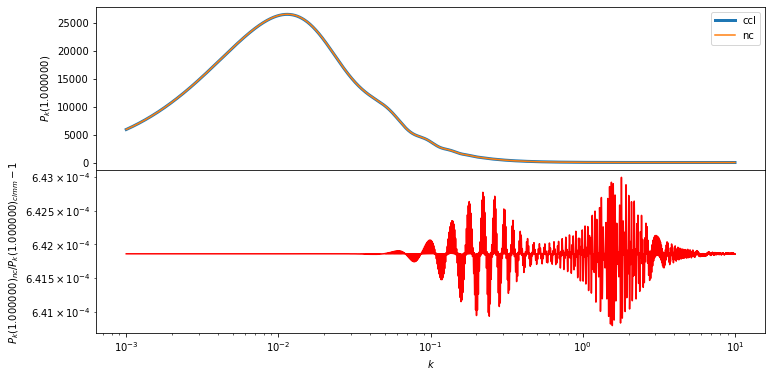

In [181]:
k = np.geomspace (1.0e-3, 1.0e1, 10000)
z = [0.0, 0.5, 1.0]
compare_ps (k, z, 0.7, -1.0, 0.0)
